<a id='BacktoTop'></a>

### SMU NLP Course (DS7337) -- Final Project (submission due on 08-12-2019)

#### Topic Modeling of IMDB Movie Reviews with Nonnegative Matrix Factorization (NMF) and Latent Dirichlet Allocation (LDA) 

### Shanqing Gu (Class 401)

###  Table of Contents: 

#### [1. Data Preparation](#dataPrep)
   * [1.1 Load IMDB Movie Review Dataset from Homework 8 ](#loadReview11) 
   * [1.2 Functions for Corpus Preprocessing and Normalization](#functions12) 
   * [1.3 Corpus Preprocessing and Normalization](#preprepNorm13) 
   * [1.4 Divide into Positive and Negative Movie Reviews with Review Ranking and Polarity](#posNeg14) 
   
#### [2. Topic Modeling with NMF and LDA](#TMNMF)
   * [2.1 Topic Modeling with NMF](#TMNMF21)
     * [2.1.1 - TF-IDF Vectorization, Positive review topic modeling with NMF using Scikit-Learn, and visualization with pyLDAvis](#TMNMF211p)
     * [2.1.2 - TF-IDF Vectorization, Negative review topic modeling with NMF using Scikit-Learn, and visualization with pyLDAvis](#TMNMF212n)
   
   * [2.2 Topic Modeling with LDA](#TMLDA22)
     * [2.2.1 - TF-IDF Vectorization, Positive review topic modeling with LDA using Scikit-Learn, and visualization with pyLDAvis](#TMLDA221p)
     * [2.2.2 - TF-IDF Vectorization, Negative review topic modeling with LDA using Scikit-Learn, and visualization with pyLDAvis](#TMLDA222n)

#### 3. [Topic Modeling Summary](#Summary)   

#### Import libraries needed for final topic modeling project

In [1]:
import pandas as pd
import numpy as np
import pickle
import re
import string
import collections
import seaborn as sns
import html

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation

import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn

from pattern.en import tag

from contractions import CONTRACTION_MAP
from textblob import TextBlob

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

total_topics = 6

<a id='dataPrep'></a>

### 1. Data Preparation

In previous homework, 956 IMDb reviews from 47 thriller movies are extracted with BeautifulSoup web scraping. The reviews are scaled to 1 for positive movie review based on rating higher than '7/10' and others as 0 for negative. There are 423 movie reviews assigned to "1" as positive reviews and 533 movie reviews assigned to "0" as negative reviews.

For preprocessing, expand_contractions() is used for expand sentence contractions, lemming() to remove word affixes and get a base form of the word, and remove_stopwords() to remove stopwords. The collected reviews are cleaned and tokenized with pattern library. 

In sentiment analysis, polarity refers to the emotion expressed in the sentence (positive, neutral, and negative). TextBlob lexicon is one of the popular lexicon models used for sentiment analysis. The polarity value for scale 0 (mean=0.03, quantile 0.25 level) indicates most emotion expressions are almost neutral, and scale 1 is more positive and has higher polarity value (mean=0.22, quantile 0.75 level). The barplot and swarmplot show the sample distribution.

[Back to top](#BacktoTop)

<a id='loadReview11'></a>

#### 1.1 Load IMDB Movie Review Dataset from Homework 8
Use the preprocessed movie reviews from homework 08 (MoviesReviews_km4_pws.p). 956 IMDb reviews from 47 thriller movies are extracted with BeautifulSoup web scraping. The reviews are scaled to 1 for positive movie review based on rating higher than '7/10' and others as 0 for negative. There are 423 movie reviews assigned to "1" as positive reviews and 533 movie reviews assigned to "0" as negative reviews.

[Back to top](#BacktoTop)

In [2]:
## Movie review data <'MoviesReviews_km4_pws.p'> was from HW-08
## Introduced in Q1.1.3 from HW07 with codes: pickle.dump(MoviesReviews, open( "MoviesReviews_km4_pws.p", "wb" ) , protocol=2)
with open('MoviesReviews_km4_pws.p', 'rb') as f:
    MoviesReviews = pickle.load(f)

In [3]:
## Check movie review data with head()
MoviesReviews.head(3)

,Movie,rRating,rTitle,rReview,rAuthor,rDate,rLink,Scale,Chunks,Tokens,km4_pws
0,A Quiet Place,10/10,For all the bashers of this movie,1) The actress who is deaf in the movie is dea...,shaneandamy-196294,August/2018,http://www.imdb.com/review/rw4267600/?ref_=tt_...,1,"[the actress, is, deaf, in, the movie, is, dea...","[actress, deaf, movie, deaf, real, life, alien...",2
1,A Quiet Place,10/10,Love it!,I am Deaf. I realllllly enjoy it!! So it good ...,zechpetersen7,April/2018,http://www.imdb.com/review/rw4119874/?ref_=tt_...,1,"[i, am, deaf, i, realllllly enjoy, it, so, it,...","[deaf, realllllly, enjoy, good, people, know, ...",2
2,A Quiet Place,8/10,"Nicely done horror + thriller, quite recommen...","""A Quiet Place"" directed by John Krasinski is ...",NpMoviez17,July/2018,http://www.imdb.com/review/rw4242428/?ref_=tt_...,1,"[a quiet place, directed, by, john krasinski, ...","[quiet, place, direct, john, krasinski, genuin...",0


In [4]:
## check data shape of movie reviews: 956 
MoviesReviews.shape

(956, 11)

In [5]:
## count variable "Scale": "1" for 423 and "0" for 533 instances
collections.Counter(MoviesReviews.Scale)

Counter({1: 423, 0: 533})

<a id='functions12'></a>

#### 1.2 Functions for Corpus Preprocessing and Normalization 

For preprocessing, expand_contractions() is used for expand sentence contractions, lemming() to remove word affixes and get a base form of the word, and remove_stopwords() to remove stopwords. The collected reviews are cleaned and tokenized with pattern library.

[Back to top](#BacktoTop)

In [6]:
## normalize_corpus function to normalize corpus
def normalize_corpus(corpus, lemmatize=True, only_text_chars=False, tokenize=False):
    
    normalized_corpus = []    
    
    for text in corpus:         
        text = html.unescape(text) 
        text = expand_contractions(text, CONTRACTION_MAP)
        
        if lemmatize:
            text = lemmatize_text(text)
        else:
            text = text.lower()
        text = remove_special_characters(text)
        text = remove_stopwords(text)
        
        if only_text_chars:
            text = keep_text_characters(text)
        
        if tokenize:
            text = tokenize_text(text)
            normalized_corpus.append(text)
        else:
            normalized_corpus.append(text)
            
    return normalized_corpus

In [7]:
## expand_contractions function to expand contractions
def expand_contractions(text, contraction_mapping):
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())),
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                               if contraction_mapping.get(match)\
                               else contraction_mapping.get(match.lower())
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [8]:
## remove_special_characters function to remove special characters
def remove_special_characters(text):
    tokens = tokenize_text(text)
    pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
    filtered_tokens = filter(None, [pattern.sub(' ', token) for token in tokens])
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [9]:
## tokenize_text function for tokenization
def tokenize_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    return tokens

In [10]:
## remove_stopwords function to remove stop words
def remove_stopwords(text):
    tokens = tokenize_text(text)
    stopword_list = nltk.corpus.stopwords.words('english')
    stopword_list.extend(['movie', 'film', 'review', 'one', 'watch', 'story', 'time', 'look', 'plot', 'go', 'see', 'think',
                          'end', 'feel', 'moment', 'cast', 'play', 'thing', 'way', 'need', 'character', 'get', 'make', 'find', 'like', 'good']) # add 24 stopwords
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [11]:
# annotate text tokens with POS tags
def pos_tag_text(text):
    
    def penn_to_wn_tags(pos_tag): 
        if pos_tag.startswith('J'): 
            return wn.ADJ
        elif pos_tag.startswith('V'):
            return wn.VERB
        elif pos_tag.startswith('N'):
            return wn.NOUN
        elif pos_tag.startswith('R'):
            return wn.ADV
        else:
            return None
    
    tagged_text = tag(text)
    tagged_lower_text = [(word.lower(), penn_to_wn_tags(pos_tag)) for word, pos_tag in tagged_text]
    return tagged_lower_text

In [12]:
## lemmatize text based on POS tags
def lemmatize_text(text):    
    wnl = WordNetLemmatizer()    
    pos_tagged_text = pos_tag_text(text)
    lemmatized_tokens = [wnl.lemmatize(word, pos_tag) if pos_tag else word for word, pos_tag in pos_tagged_text]
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text    

<a id='preprepNorm13'></a>

#### 1.3 Corpus Preprocessing and Normalization 

Polarity refers to the emotion expressed in the sentence (positive, neutral, and negative). TextBlob lexicon is one of the popular lexicon models used for sentiment analysis.

[Back to top](#BacktoTop)

In [13]:
## normalize rReview and save in variable "Corpus"
MoviesReviews["Corpus"] = normalize_corpus(MoviesReviews.rReview, lemmatize=True )

In [14]:
## calculate polarity and subjectivity for individual movie review with TextBlob
MoviesReviews['Polarity'] = MoviesReviews['Corpus'].apply(lambda x: TextBlob(x).sentiment.polarity)
MoviesReviews['Subjectivity'] = MoviesReviews['Corpus'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
MoviesReviews.head(2)

,Movie,rRating,rTitle,rReview,rAuthor,rDate,rLink,Scale,Chunks,Tokens,km4_pws,Corpus,Polarity,Subjectivity
0,A Quiet Place,10/10,For all the bashers of this movie,1) The actress who is deaf in the movie is dea...,shaneandamy-196294,August/2018,http://www.imdb.com/review/rw4267600/?ref_=tt_...,1,"[the actress, is, deaf, in, the movie, is, dea...","[actress, deaf, movie, deaf, real, life, alien...",2,1 actress deaf deaf real life 2 alien blind 3 ...,0.042938,0.481845
1,A Quiet Place,10/10,Love it!,I am Deaf. I realllllly enjoy it!! So it good ...,zechpetersen7,April/2018,http://www.imdb.com/review/rw4119874/?ref_=tt_...,1,"[i, am, deaf, i, realllllly enjoy, it, so, it,...","[deaf, realllllly, enjoy, good, people, know, ...",2,deaf realllllly enjoy people know sign langurg...,0.250000,0.300000


<a id='posNeg14'></a>

#### 1.4 Divide into Positive and Negative Movie Reviews with Review Ranking and Polarity

The polarity value for scale 0 (mean=0.03, quantile 0.25 level) indicates most emotion expressions are almost neutral, and scale 1 is more positive and has higher polarity value (mean=0.22, quantile 0.75 level). The barplot and swarmplot show the sample distribution.

[Back to top](#BacktoTop)

In [15]:
## compute the average, median, high, and low sentiment scores for two classes (Scale= 0 or 1)
MoviesReviews.groupby('Scale', as_index=True).agg({"Polarity":['count', 'min', 'mean', 'median', 'max']})

Polarity                              
         count  min      mean    median  max
Scale                                       
0          533 -0.6  0.006747  0.009167  0.7
1          423 -0.8  0.202591  0.185257  1.0

In [16]:
## return values at the given quantiles at 0.1, 0.25, 0.50, and 0.75
MoviesReviews['Polarity'].quantile([0.1, 0.25, 0.5, 0.75])

0.10   -0.133705
0.25   -0.016186
0.50    0.093542
0.75    0.200000
Name: Polarity, dtype: float64

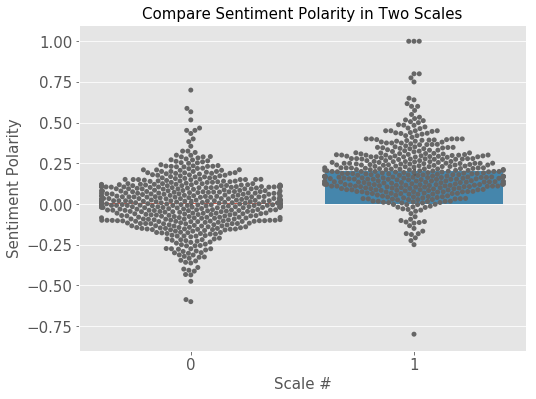

In [17]:
## use barplot and swarmplot to compare the sentiment polarity for two classes (Scale= 0 or 1)
sns.set_palette("husl")
plt.style.use('ggplot')

plt.figure(figsize=(8,6))
b = sns.barplot(x = "Scale", y = "Polarity", data = MoviesReviews)
s= sns.swarmplot(x = "Scale", y = "Polarity", data = MoviesReviews, color=".4")

b.axes.set_title("Compare Sentiment Polarity in Two Scales",fontsize=15)
b.set_xlabel("Scale #", fontsize=15)
b.set_ylabel("Sentiment Polarity",fontsize=15)
b.tick_params(labelsize=15)

plt.savefig('scale_pws_pol.png', dpi=300)

In [18]:
## "Positive" when 'Scale' is 1, and "Negative" when 'Scale' is 0 
## "Positive" for rRating ('10/10','9/10', '8/10', '7/10') and others as "Negative"
p_sm=MoviesReviews[MoviesReviews['Scale']==1].copy()
p_sm['SM']='Positive'

n_sm=MoviesReviews[MoviesReviews['Scale']==0].copy()
n_sm['SM']='Negative'

MoviesReviews_sm=pd.concat([p_sm, n_sm],axis=0)

In [19]:
## reviews and sentiments for model evaluation
reviews = np.array(MoviesReviews_sm['Corpus'])
sentiments = np.array(MoviesReviews_sm['SM'])
positive_reviews = [reviews for reviews, sentiments in zip(reviews, sentiments)if sentiments == 'Positive']
negative_reviews = [reviews for reviews, sentiments in zip(reviews, sentiments)if sentiments == 'Negative']

<a id='TMNMF'></a>

### 2. Topic Modeling with NMF and LDA

Topic modelling is described as a method of uncovering hidden structure in a collection of texts. It is a form of dimensionality reduction.

Organic Topic Modeling is to discover the natural topics of a corpus. The ideal is to let topics bubble up from out of the lake of unstructured documents. Organic topic modeling is the type more popular than canonical or entity-centric topic modeling. The reason is that it is the only one to crunch big data with statistics. Organic topic modeling starts from an authoritative list of topics. There are 3 ways to implement organic topic modeling: latent semantic analysis (LSA), latent Dirichlet allocation (LDA) and non-negative matrix factorization (NMF).

[Back to top](#BacktoTop)

<a id='TMNMF21'></a>

#### 2.1 Topic Modeling with NMF

Non-negative matrix factorization (NMF) is one matrix decomposition technique similar to SVD but operates on non-negative matrices and works well for multivariate data. NMF topic modeling is the best choice for short text topic mining than popular LDA-based methods. The classically noisy and sparse short texts lack sufficient information for LDA, while NMF contains much more priors such as TF–IDF encodings for texts (instead of the only TF in LDA).

[Back to top](#BacktoTop)

<a id='TMNMF211p'></a>

#### 2.1.1 TF-IDF Vectorization, Positive Movie Review Topic Modeling with NMF Using Scikit-Learn, and Visualization with pyLDAvis

There are two algorithms for word vectorization: Bag of Words (Bow) and Term-frequency-inverse document frequency (TF-IDF).

BoW is to count the word frequency in a document for comparing documents and gauge their similarities for applications. 

Comparatively, TF-IDF is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.  The substitution TF with TF-IDF in the vectors will give a much higher cosine similarity. TF-IDF helps to adjust for the fact that some words appear more frequently in general. TF-IDF is one of the most popular term-weighting schemes today. 

TF-IDF is used for word vectorization, Scikit-Learn is used for positive movie review topic modeling with NMF.

For model visualization, pyLDAvis is used to interpret the topics in the topic model that has been fit to a corpus of text data. The package extracts information from a fitted NMF topic model to inform an interactive web-based visualization. Typically, dimension reduction techniques like MDS, PDA, and t-SNE are used to visualize the topics in a two-dimensional visual. The visualization is saved to a stand-alone HTML file for easy sharing.

[Back to top](#BacktoTop)


#### 2.1.1.1 TF-IDF Vectorization

In [20]:
## convert to a TF-IDF weighted Term-Document Matrix (TDM)
ptvf = TfidfVectorizer(use_idf = True, min_df = 0.02, max_df=0.75, ngram_range=(1,2), sublinear_tf=True)
ptvf_features = ptvf.fit_transform(positive_reviews) 
print(ptvf_features.shape) ## there are 423 positive reviews with 905 features after TF-IDF vectorization

pos_feature_names = np.array(ptvf.get_feature_names())

(423, 900)


#### 2.1.1.2 Positive Movie Review Topic Modeling with NMF Using Scikit-Learn

In [21]:
## apply NMF
pos_nmf = NMF(n_components=total_topics, solver='cd', max_iter=500, random_state=42, alpha=0.1,  l1_ratio=0.85) ## NMF
pos_nmf.fit(ptvf_features) ## W

# pos_feature_names = np.array(ptvf.get_feature_names())
pos_weights=pos_nmf.components_ ## H

In [22]:
## generate topics from the NMF model
pos_feature_idxs=np.argsort(-pos_weights)[:, :15]
pos_feature = pos_feature_names[pos_feature_idxs]
pos_topics = [', '.join(topic) for topic in pos_feature]
pd.set_option('display.max_colwidth', -1)
pos_topics_df = pd.DataFrame(pos_topics, columns = ['Term per Topic'], index = ['Topic'+str(t) for t in range(1, len(pos_topics)+1)])
pos_topics_df

,Term per Topic
Topic1,"well, great, really, love, would, first, also, scene, say, people, even, give, know, best, much"
Topic2,"fun, interesting, action, enjoy, comedy, great, overall, 10, powerful, power, post, possibly, possible, positive, portray"
Topic3,"anderson, wes, wes anderson, dog, japanese, animation, island, motion, style, stop, detail, voice, mr, jeff, city"
Topic4,"dog, guy, japanese, beautifully, art, believable, political, draw, human, style, help, kind, away, tell, bad"
Topic5,"infinity, infinity war, war, marvel, ant, ant man, avenger, thanos, mcu, man, paul, event, civil war, civil, scale"
Topic6,"hardy, tom hardy, tom, venom, critic, great, listen, thoroughly, theatre, nothing, awesome, hope, know, perfect, negative"


In [23]:
## view the topic dominance per document using the document-topiic matrix
pos_topics = pos_nmf.fit_transform(ptvf_features)

pd.options.display.float_format = '{:,.4f}'.format
pos_df = pd.DataFrame(pos_topics, columns = ['T'+str(i) for i in range(1, total_topics+1)])
pos_df.head(15).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
T1,0.0734,0.0574,0.1695,0.1376,0.1019,0.1993,0.0806,0.1005,0.1037,0.0658,0.0665,0.0413,0.0566,0.0805,0.0502
T2,0.0052,0.0432,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0072,0.0611,0.0000,0.0000,0.0000,0.1314,0.0000
T3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
T4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
T5,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
T6,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [24]:
## view each topic and corresponding paper with its maximum contribution
rRevAuthor = MoviesReviews['rAuthor']

# pd.options.display.float_format = '{:,.4f}'.format
pd.set_option('display.max_colwidth', 100)

max_score_topics = pos_df.max(axis=0)
main_topics = max_score_topics.index
term_score = max_score_topics.values

rReview_numbers = [pos_df[pos_df[t]==max_score_topics.loc[t]].index[0] for t in main_topics]
rReviews = [rRevAuthor[i] for i in rReview_numbers]

posNMF_results_df = pd.DataFrame({'Main Topic': main_topics, 
                                  'Max Score': term_score, 
                                  'rReview #': rReview_numbers,
                                  'Terms per Topic': pos_topics_df['Term per Topic'],
                                  'rAuthor': rReviews})
posNMF_results_df

,Main Topic,Max Score,rReview #,Terms per Topic,rAuthor
Topic1,T1,0.2672,227,"well, great, really, love, would, first, also, scene, say, people, even, give, know, best, much",Crim-28
Topic2,T2,0.4959,407,"fun, interesting, action, enjoy, comedy, great, overall, 10, powerful, power, post, possibly, po...",alicepetit9
Topic3,T3,0.5124,207,"anderson, wes, wes anderson, dog, japanese, animation, island, motion, style, stop, detail, voic...",kmeditions10
Topic4,T4,1.4685,206,"dog, guy, japanese, beautifully, art, believable, political, draw, human, style, help, kind, awa...",neo-5056010
Topic5,T5,0.4037,34,"infinity, infinity war, war, marvel, ant, ant man, avenger, thanos, mcu, man, paul, event, civil...",fabi-sp9228
Topic6,T6,0.4919,415,"hardy, tom hardy, tom, venom, critic, great, listen, thoroughly, theatre, nothing, awesome, hope...",recklesscow19


#### 2.1.1.3 Visualize Positive Topics from the NMF Model with pyLDAvis

pyLDAvis is used to interpret the topics in the topic model that has been fit to a corpus of text data. The package extracts information from a fitted NMF topic model to inform an interactive web-based visualization. Typically, dimension reduction techniques like MDS, PDA, and t-SNE are used to visualize the topics in a two-dimensional visual. The visualization is saved to a stand-alone HTML file for easy sharing.

The function mds takes 'topic_term_dists' as an input and outputs a 'n_topics' by 2 distance matrices. The output approximates the distance between topics. The default MDS function is PCoA, and MMDS and TSNE can also be used for plotting. Here, use mds = 'mmds'.

In [25]:
## visulize positive topics from the NMF model with pyLDAvis
posNMF_panel = pyLDAvis.sklearn.prepare(pos_nmf, ptvf_features, ptvf, mds='mmds') # 'mmds' is better than 'tsne'
posNMF_panel 

PreparedData(topic_coordinates=            x       y  topics  cluster    Freq
topic                                         
0      0.0202 -0.0419       1        1 85.4241
4     -0.1652 -0.4312       2        1  5.1175
1     -0.4654  0.0285       3        1  3.9004
2     -0.0758  0.4075       4        1  2.8810
5      0.3656 -0.2710       5        1  2.4957
3      0.3206  0.3081       6        1  0.1812, topic_info=    Category    Freq             Term   Total  loglift  logprob
328  Default 47.0000              fun 47.0000  30.0000  30.0000
10   Default 37.0000           action 37.0000  29.0000  29.0000
416  Default 29.0000      interesting 29.0000  28.0000  28.0000
861  Default 18.0000              war 18.0000  27.0000  27.0000
571  Default 12.0000           people 12.0000  26.0000  26.0000
410  Default 16.0000         infinity 16.0000  25.0000  25.0000
411  Default 15.0000     infinity war 15.0000  24.0000  24.0000
346  Default 19.0000            great 19.0000  23.0000  23.0000
486  Default 15.0000           marvel 15.0000  22.0000  22.0000
211  Default  8.0000              dog  8.0000  21.0000  21.0000
41   Default 10.0000         anderson 10.0000  20.0000  20.0000
66   Default  6.0000              bad  6.0000  19.0000  19.0000
811  Default  9.0000              tom  9.0000  18.0000  18.0000
361  Default  9.0000            hardy  9.0000  17.0000  17.0000
812  Default  9.0000        tom hardy  9.0000  16.0000  16.0000
864  Default  9.0000              wes  9.0000  15.0000  15.0000
788  Default  6.0000             tell  6.0000  14.0000  14.0000
865  Default  8.0000     wes anderson  8.0000  13.0000  13.0000
62   Default  5.0000             away  5.0000  12.0000  12.0000
443  Default 12.0000             know 12.0000  11.0000  11.0000
442  Default  4.0000             kind  4.0000  10.0000  10.0000
173  Default  6.0000           critic  6.0000   9.0000   9.0000
844  Default  6.0000            venom  6.0000   8.0000   8.0000
352  Default  3.0000              guy  3.0000   7.0000   7.0000
237  Default 10.0000            enjoy 10.0000   6.0000   6.0000
766  Default  5.0000            style  5.0000   5.0000   5.0000
369  Default  3.0000             help  3.0000   4.0000   4.0000
886  Default 13.0000            would 13.0000   3.0000   3.0000
60   Default  7.0000          avenger  7.0000   2.0000   2.0000
482  Default  9.0000              man  9.0000   1.0000   1.0000
..       ...     ...              ...     ...      ...      ...
66    Topic6  0.1643              bad  6.3816   2.6534  -3.3459
571   Topic6  0.1114           people 12.0313   1.6307  -3.7345
0     Topic6  0.0000               10  8.4789     -inf     -inf
1     Topic6  0.0000            10 10  1.4346     -inf     -inf
2     Topic6  0.0000               20  1.3328     -inf     -inf
3     Topic6  0.0000             2018  3.2674     -inf     -inf
4     Topic6  0.0000          ability  1.1951     -inf     -inf
5     Topic6  0.0000             able  2.4417     -inf     -inf
6     Topic6  0.0000       absolutely  3.6620     -inf     -inf
7     Topic6  0.0000           accept  0.8026     -inf     -inf
8     Topic6  0.0000              act  5.4948     -inf     -inf
9     Topic6  0.0000           acting  5.6698     -inf     -inf
10    Topic6  0.0000           action 37.0555     -inf     -inf
11    Topic6  0.0000     action scene  3.1654     -inf     -inf
12    Topic6  0.0000  action sequence  2.0739     -inf     -inf
13    Topic6  0.0000            actor  6.1595     -inf     -inf
300   Topic6  0.0000            final  2.3478     -inf     -inf
301   Topic6  0.0000           finale  1.1719     -inf     -inf
299   Topic6  0.0000       filmmaking  1.1151     -inf     -inf
302   Topic6  0.0000          finally  2.4712     -inf     -inf
298   Topic6  0.0000        filmmaker  1.1394     -inf     -inf
297   Topic6  0.0000             fill  1.9893     -inf     -inf
303   Topic6  0.0000             fine  1.5350     -inf     -inf
899   Topic6  0.0000            young  2.1878     -inf     -i

<a id='TMNMF212n'></a>

#### 2.1.2 TF-IDF Vectorization, Negative Movie Review Topic Modeling with NMF Using Scikit-Learn, and Visualization with pyLDAvis

[Back to top](#BacktoTop)

#### 2.1.2.1 TF-IDF Vectorization

In [26]:
## convert to a TF-IDF weighted Term-Document Matrix (TDM)
ntvf = TfidfVectorizer(use_idf = True, min_df = 0.02, max_df=0.75, ngram_range=(1,2), sublinear_tf=True)
ntvf_features = ntvf.fit_transform(negative_reviews)
print(ntvf_features.shape) ## there are 533 negative reviews with 818 features after TF-IDF vectorization

neg_feature_names = np.array(ntvf.get_feature_names())

(533, 812)


#### 2.1.2.2 Negative Movie Review Topic Modeling with NMF Using Scikit-Learn

In [27]:
## apply NMF
neg_nmf = NMF(n_components=total_topics, solver='cd', max_iter=500, random_state=42, alpha=0.1,  l1_ratio=0.85) ## NMF
neg_nmf.fit(ntvf_features) ## W

# neg_feature_names = np.array(ntvf.get_feature_names())
neg_weights=neg_nmf.components_ # H

In [28]:
## generate topics from the NMF model
neg_feature_idxs=np.argsort(-neg_weights)[:, :15]
neg_feature = neg_feature_names[neg_feature_idxs]
neg_topics = [', '.join(topic) for topic in neg_feature]
pd.set_option('display.max_colwidth', -1)
neg_topics_df = pd.DataFrame(neg_topics, columns = ['Term per Topic'], index = ['Topic'+str(t) for t in range(1, len(neg_topics)+1)])
neg_topics_df

,Term per Topic
Topic1,"would, really, first, bad, scene, even, well, could, much, people, say, know, give, great, many"
Topic2,"waste, waste money, money, total, totally, saw, cheesy, awful, terrible, hour, boring, super, first, strong, funny"
Topic3,"nun, scare, horror, scary, acting, jump, act, screenplay, miss, almost, reason, direction, creepy, script, universe"
Topic4,"year old, old, year, write, direct, parent, writing, blockbuster, part, 10, drag, long, wrong, half, five"
Topic5,"bore, funny, nothing, first, cash, please, next, try, tv, cut, point, pointless, poor, poorly, pop"
Topic6,"star war, solo, war, star, entertaining, full, action, job, disney, last, must, meet, robot, stand, bad"


In [29]:
## view the topic dominance per document using the document-topiic matrix
neg_topics = neg_nmf.fit_transform(ntvf_features)

pd.options.display.float_format = '{:,.4f}'.format
neg_df = pd.DataFrame(neg_topics, columns = ['T'+str(i) for i in range(1, total_topics+1)])
neg_df.head(15).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
T1,0.1555,0.1411,0.1517,0.1227,0.1259,0.0877,0.1428,0.0948,0.0743,0.1424,0.0730,0.1165,0.1235,0.0966,0.0908
T2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
T3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0205,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
T4,0.0000,0.0000,0.0287,0.0000,0.1267,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0834
T5,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
T6,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [30]:
## view each topic and corresponding movie review with its maximum contribution
rRevAuthor = MoviesReviews['rAuthor']

pd.options.display.float_format = '{:,.4f}'.format
pd.set_option('display.max_colwidth', 100)

max_score_topics = neg_df.max(axis=0)
main_topics = max_score_topics.index
term_score = max_score_topics.values

rReview_numbers = [neg_df[neg_df[t]==max_score_topics.loc[t]].index[0] for t in main_topics]
rReviews = [rRevAuthor[i] for i in rReview_numbers]

NegNMF_results_df = pd.DataFrame({'Main Topic':main_topics, 
                                  'Max Score': term_score,
                                  'rReview #': rReview_numbers,
                                  'Term per Topic':neg_topics_df['Term per Topic'],
                                  'rAuthor': rReviews})
NegNMF_results_df

,Main Topic,Max Score,rReview #,Term per Topic,rAuthor
Topic1,T1,0.2246,479,"would, really, first, bad, scene, even, well, could, much, people, say, know, give, great, many",lbenot12
Topic2,T2,0.3000,172,"waste, waste money, money, total, totally, saw, cheesy, awful, terrible, hour, boring, super, fi...",Yee_Reviews1
Topic3,T3,0.5620,485,"nun, scare, horror, scary, acting, jump, act, screenplay, miss, almost, reason, direction, creep...",ewzzang31
Topic4,T4,0.4981,507,"year old, old, year, write, direct, parent, writing, blockbuster, part, 10, drag, long, wrong, h...",atomikbuster17
Topic5,T5,0.3831,191,"bore, funny, nothing, first, cash, please, next, try, tv, cut, point, pointless, poor, poorly, pop",danieltaller23
Topic6,T6,0.5468,411,"star war, solo, war, star, entertaining, full, action, job, disney, last, must, meet, robot, sta...",MWNiese19


#### 2.1.2.3 Visualize Negative Topics from the NMF Model with pyLDAvis

In [31]:
## visulize negative topics from the NMF model with pyLDAvis
negNMF_panel = pyLDAvis.sklearn.prepare(neg_nmf, ntvf_features, ntvf, mds='mmds') # 'mmds' is better than 'tsne'
negNMF_panel

PreparedData(topic_coordinates=            x       y  topics  cluster    Freq
topic                                         
0     -0.0426  0.0868       1        1 85.9180
1      0.4470  0.0671       2        1  4.1155
3     -0.4512  0.1350       3        1  2.8434
5      0.2265 -0.3919       4        1  2.8210
4      0.0894  0.4661       5        1  2.5874
2     -0.2692 -0.3632       6        1  1.7146, topic_info=    Category    Freq         Term   Total  loglift  logprob
778  Default 54.0000        waste 54.0000  30.0000  30.0000
97   Default 45.0000         bore 45.0000  29.0000  29.0000
507  Default 24.0000          old 24.0000  28.0000  28.0000
807  Default 24.0000     year old 24.0000  27.0000  27.0000
497  Default 21.0000          nun 21.0000  26.0000  26.0000
806  Default 23.0000         year 23.0000  25.0000  25.0000
680  Default 20.0000     star war 20.0000  24.0000  24.0000
679  Default 21.0000         star 21.0000  23.0000  23.0000
777  Default 20.0000          war 20.0000  22.0000  22.0000
466  Default 23.0000        money 23.0000  21.0000  21.0000
292  Default 23.0000        first 23.0000  20.0000  20.0000
662  Default 18.0000         solo 18.0000  19.0000  19.0000
779  Default 19.0000  waste money 19.0000  18.0000  18.0000
494  Default 17.0000      nothing 17.0000  17.0000  17.0000
311  Default 14.0000        funny 14.0000  16.0000  16.0000
736  Default 13.0000        total 13.0000  15.0000  15.0000
802  Default 12.0000        write 12.0000  14.0000  14.0000
12   Default 10.0000       acting 10.0000  13.0000  13.0000
614  Default  9.0000        scare  9.0000  12.0000  12.0000
356  Default  9.0000       horror  9.0000  11.0000  11.0000
744  Default 12.0000          try 12.0000  10.0000  10.0000
13   Default 13.0000       action 13.0000   9.0000   9.0000
737  Default  9.0000      totally  9.0000   8.0000   8.0000
11   Default  8.0000          act  8.0000   7.0000   7.0000
486  Default  8.0000         next  8.0000   6.0000   6.0000
521  Default 10.0000         part 10.0000   5.0000   5.0000
0    Default 10.0000           10 10.0000   4.0000   4.0000
804  Default  8.0000      writing  8.0000   3.0000   3.0000
615  Default  6.0000        scary  6.0000   2.0000   2.0000
27   Default  7.0000       almost  7.0000   1.0000   1.0000
..       ...     ...          ...     ...      ...      ...
462   Topic6  1.1389         miss  5.2957   2.5292  -3.8331
11    Topic6  1.4747          act  8.6016   2.3025  -3.5748
582   Topic6  0.9853       reason  6.2215   2.2232  -3.9780
27    Topic6  1.0865       almost  7.0074   2.2019  -3.8803
757   Topic6  0.3696     universe  2.5578   2.1315  -4.9586
126   Topic6  0.1858        cheap  2.0550   1.6624  -5.6465
625   Topic6  0.4981       script  6.7532   1.4590  -4.6602
720   Topic6  0.1135      tension  2.5960   0.9364  -6.1388
309   Topic6  0.1830         full  6.2969   0.5274  -5.6617
641   Topic6  0.0288        shoot  1.0729   0.4470  -7.5118
550   Topic6  0.0571  predictable  5.5709  -0.5146  -6.8262
778   Topic6  0.0500        waste 54.3377  -2.9255  -6.9595
0     Topic6  0.0000           10 10.7627     -inf     -inf
1     Topic6  0.0000           13  1.0173     -inf     -inf
2     Topic6  0.0000           15  2.4513     -inf     -inf
3     Topic6  0.0000    15 minute  1.0768     -inf     -inf
4     Topic6  0.0000           20  3.2938     -inf     -inf
5     Topic6  0.0000    20 minute  1.6957     -inf     -inf
6     Topic6  0.0000         2018  2.4403     -inf     -inf
7     Topic6  0.0000           30  2.9395     -inf     -inf
8     Topic6  0.0000         able  2.0544     -inf     -inf
266   Topic6  0.0000         fact  5.7057     -inf     -inf
267   Topic6  0.0000         fail  3.6621     -inf     -inf
265   Topic6  0.0000         face  3.9244     -inf     -inf
268   Topic6  0.0000       fairly  1.1138     -inf     -inf
811   Topic6  0.0000         zero  1.1785     -inf     -inf
264   Topic6  0.0000          eye  2.4327     -inf     -inf
263   Topic6  0.0000    extremely  3.6718

<a id='TMLDA22'></a>

#### 2.2 Topic Modeling with LDA

Latent Dirichlet Allocation (LDA) is to use a generative probabilistic model where each document consists of a combination of several topics and each term or word can be assigned to a specific topic. There are two important concentration parameters: alpha and beta. When using LDA for topic modeling, a higher alpha value will lead to Documents being more similar in terms of what topics they contain

[Back to top](#BacktoTop)

<a id='TMLDA221p'></a>

#### 2.2.1 TF-IDF Vectorization, Positive movie review topic modeling with LDA using Scikit-Learn, and visualization with pyLDAvis

TF-IDF is used for word vectorization, Scikit-Learn is used for positive movie review topic modeling with NMF and pyLDAvis is used for visualization.

[Back to top](#BacktoTop)

#### 2.2.1.1 TF-IDF Vectorization

TF-IDF Vectorization is conducted in Section 2.1.1.1, ptvf_features includes 423 positive reviews with 905 features after TF-IDF vectorization.

#### 2.2.1.2 Positive movie review topic modeling with LDA using Scikit-Learn

In [32]:
## build LDA topic model for positive movie reviews
pos_top_terms = 10
pos_lda_model = LatentDirichletAllocation(n_components = total_topics, max_iter=500, max_doc_update_iter=50, learning_method='online',
                                          batch_size=1740, learning_offset=50, random_state=42, n_jobs=16)
pos_lda_topics = pos_lda_model.fit_transform(ptvf_features)

In [33]:
## generate topics from LDA topic model
pos_lda_topic_terms = pos_lda_model.components_
pos_lda_topic_key_term_idxs = np.argsort(-np.absolute(pos_lda_topic_terms), axis=1)[:, :pos_top_terms]
pos_lda_vocabulary = np.array(ptvf.get_feature_names())
pos_lda_topic_key_terms = pos_lda_vocabulary[pos_lda_topic_key_term_idxs]
pos_topics = [', '.join(topic) for topic in pos_lda_topic_key_terms]
pd.set_option('display.max_colwidth', 100)
pos_topic_df =pd.DataFrame(pos_topics, columns = ['Term per Topic'], index=['Topic'+str(t) for t in range(1, total_topics+1)])
pos_topic_df

,Term per Topic
Topic1,"classic, phenomenal, remake, etc, lady, result, soundtrack, almost, cinematography, acting"
Topic2,"justice, phenomenal, please, tense, absolutely, pretty, genre, event, series, brilliant"
Topic3,"ant, ant man, great, chapter, hop, venom, first, mother, animated, violent"
Topic4,"chris, favorite, far, love, girl, 10, people, sign, non, rating"
Topic5,"masterpiece, experience, young, understand, deadpool, ryan, hilarious, usually, life, know"
Topic6,"great, well, love, really, action, people, would, first, best, say"


In [34]:
## view each topic and corresponding movie review with its maximum contribution
pdt_df =pd.DataFrame(pos_lda_topics, columns = ['T'+str(t) for t in range(1, total_topics+1)])

p_rRevAuthor = MoviesReviews_sm['rAuthor']
pd.options.display.float_format = '{:,.4f}'.format
pd.set_option('display.max_colwidth', 100)

p_max_contrib_topics = pdt_df.max(axis=0)
p_main_topics = p_max_contrib_topics.index
p_contrib_perc = p_max_contrib_topics.values

p_rReview_numbers = [pdt_df[pdt_df[t]==p_max_contrib_topics.loc[t]].index[0] for t in p_main_topics]
p_rReviews = [p_rRevAuthor[i] for i in p_rReview_numbers]
p_results_df = pd.DataFrame({'Main Topic': p_main_topics, 
                             'Contribution %': p_contrib_perc,
                             'rReview #': p_rReview_numbers,
                             'Terms per Topic': pos_topic_df['Term per Topic'],
                             'rRevAuthor': p_rReviews})
p_results_df

,Main Topic,Contribution %,rReview #,Terms per Topic,rRevAuthor
Topic1,T1,0.7685,27,"classic, phenomenal, remake, etc, lady, result, soundtrack, almost, cinematography, acting",jeffreyhickman17
Topic2,T2,0.7672,186,"justice, phenomenal, please, tense, absolutely, pretty, genre, event, series, brilliant",tinhorse21
Topic3,T3,0.7639,322,"ant, ant man, great, chapter, hop, venom, first, mother, animated, violent",maiajay1315
Topic4,T4,0.7142,213,"chris, favorite, far, love, girl, 10, people, sign, non, rating",TheOneThatYouWanted3
Topic5,T5,0.8107,108,"masterpiece, experience, young, understand, deadpool, ryan, hilarious, usually, life, know",rahulnayi25
Topic6,T6,0.9481,227,"great, well, love, really, action, people, would, first, best, say",Crim-28


#### 2.2.1.3 Visualize Positive Topics from the LDA Model with pyLDAvis

In [35]:
## visulize positive topics from the LDA model with pyLDAvis
posLDA_tsne_panel = pyLDAvis.sklearn.prepare(pos_lda_model, ptvf_features, ptvf, mds='tsne') # 'tsne' is better than 'mmds' for visualization
posLDA_tsne_panel

PreparedData(topic_coordinates=              x         y  topics  cluster    Freq
topic                                             
5     -204.0799 -165.7484       1        1 87.4818
2       42.0753  225.4814       2        1  2.6933
4       72.9003 -235.7179       3        1  2.5995
0      225.0282    6.0836       4        1  2.4438
1      -17.4402  -10.1276       5        1  2.4355
3     -223.1217  119.2910       6        1  2.3461, topic_info=    Category    Freq            Term   Total  loglift  logprob
346  Default 14.0000           great 14.0000  30.0000  30.0000
477  Default 12.0000            love 12.0000  29.0000  29.0000
306  Default  9.0000           first  9.0000  28.0000  28.0000
443  Default  9.0000            know  9.0000  27.0000  27.0000
79   Default  9.0000            best  9.0000  26.0000  26.0000
461  Default  6.0000            life  6.0000  25.0000  25.0000
282  Default  5.0000             far  5.0000  24.0000  24.0000
487  Default  3.0000     masterpiece  3.0000  23.0000  23.0000
268  Default  4.0000      experience  4.0000  22.0000  22.0000
482  Default  6.0000             man  6.0000  21.0000  21.0000
142  Default  7.0000            come  7.0000  20.0000  20.0000
834  Default  4.0000      understand  4.0000  19.0000  19.0000
748  Default  7.0000            star  7.0000  18.0000  18.0000
0    Default  7.0000              10  7.0000  17.0000  17.0000
9    Default  5.0000          acting  5.0000  16.0000  16.0000
13   Default  6.0000           actor  6.0000  15.0000  15.0000
535  Default  5.0000             new  5.0000  14.0000  14.0000
256  Default  5.0000      everything  5.0000  13.0000  13.0000
91   Default  5.0000            book  5.0000  12.0000  12.0000
571  Default 10.0000          people 10.0000  11.0000  11.0000
96   Default  4.0000       brilliant  4.0000  10.0000  10.0000
438  Default  5.0000            keep  5.0000   9.0000   9.0000
628  Default  4.0000          rating  4.0000   8.0000   8.0000
788  Default  4.0000            tell  4.0000   7.0000   7.0000
840  Default  4.0000             use  4.0000   6.0000   6.0000
59   Default  4.0000        audience  4.0000   5.0000   5.0000
130  Default  4.0000  cinematography  4.0000   4.0000   4.0000
134  Default  3.0000         classic  3.0000   3.0000   3.0000
35   Default  4.0000          always  4.0000   2.0000   2.0000
857  Default  4.0000            wait  4.0000   1.0000   1.0000
..       ...     ...             ...     ...      ...      ...
160   Topic6  0.0662         control  1.3735   0.7201  -6.8152
648   Topic6  0.0662            rely  1.3790   0.7162  -6.8152
282   Topic6  0.2397             far  5.1520   0.6845  -5.5289
477   Topic6  0.1884            love 12.2921  -0.4257  -5.7695
342   Topic6  0.0662            girl  2.6662   0.0569  -6.8151
0     Topic6  0.0662              10  7.0849  -0.9204  -6.8151
571   Topic6  0.0662          people 10.6109  -1.3243  -6.8151
711   Topic6  0.0662            sign  1.8151   0.4414  -6.8151
539   Topic6  0.0662             non  1.8433   0.4260  -6.8151
628   Topic6  0.0662          rating  4.8015  -0.5314  -6.8151
46    Topic6  0.0662             ant  1.4016   0.7000  -6.8151
882   Topic6  0.0662       work well  1.7978   0.4510  -6.8151
438   Topic6  0.0662            keep  5.1438  -0.6002  -6.8151
776   Topic6  0.0662            sure  5.5219  -0.6712  -6.8151
430   Topic6  0.0662         johnson  2.7411   0.0292  -6.8151
748   Topic6  0.0662            star  7.0882  -0.9209  -6.8151
346   Topic6  0.0662           great 14.3924  -1.6291  -6.8151
9     Topic6  0.0662          acting  5.9306  -0.7426  -6.8151
863   Topic6  0.0662            well 12.8311  -1.5143  -6.8151
443   Topic6  0.0662            know  9.3616  -1.1991  -6.8151
828   Topic6  0.0662           twist  5.3290  -0.6356  -6.8152
416   Topic6  0.0662     interesting  4.8316  -0.5376  -6.8152
19    Topic6  0.0662       adventure  2.4092   0.1583  -6.8152
62    Topic6  0.0662            away  5.6292  -0.6904  -6.8152
864   Topic6  0.0662 

In [36]:
## visulize positive topics from the LDA model with pyLDAvis
posLDA_mmds_panel = pyLDAvis.sklearn.prepare(pos_lda_model, ptvf_features, ptvf, mds='mmds') # 'tsne' is better than 'mmds' for visualization
posLDA_mmds_panel

PreparedData(topic_coordinates=            x       y  topics  cluster    Freq
topic                                         
5     -0.0305 -0.0209       1        1 87.4818
2     -0.0002  0.0201       2        1  2.6933
4      0.0136 -0.0076       3        1  2.5995
0      0.0075  0.0054       4        1  2.4438
1      0.0072  0.0008       5        1  2.4355
3      0.0023  0.0023       6        1  2.3461, topic_info=    Category    Freq            Term   Total  loglift  logprob
346  Default 14.0000           great 14.0000  30.0000  30.0000
477  Default 12.0000            love 12.0000  29.0000  29.0000
306  Default  9.0000           first  9.0000  28.0000  28.0000
443  Default  9.0000            know  9.0000  27.0000  27.0000
79   Default  9.0000            best  9.0000  26.0000  26.0000
461  Default  6.0000            life  6.0000  25.0000  25.0000
282  Default  5.0000             far  5.0000  24.0000  24.0000
487  Default  3.0000     masterpiece  3.0000  23.0000  23.0000
268  Default  4.0000      experience  4.0000  22.0000  22.0000
482  Default  6.0000             man  6.0000  21.0000  21.0000
142  Default  7.0000            come  7.0000  20.0000  20.0000
834  Default  4.0000      understand  4.0000  19.0000  19.0000
748  Default  7.0000            star  7.0000  18.0000  18.0000
0    Default  7.0000              10  7.0000  17.0000  17.0000
9    Default  5.0000          acting  5.0000  16.0000  16.0000
13   Default  6.0000           actor  6.0000  15.0000  15.0000
535  Default  5.0000             new  5.0000  14.0000  14.0000
256  Default  5.0000      everything  5.0000  13.0000  13.0000
91   Default  5.0000            book  5.0000  12.0000  12.0000
571  Default 10.0000          people 10.0000  11.0000  11.0000
96   Default  4.0000       brilliant  4.0000  10.0000  10.0000
438  Default  5.0000            keep  5.0000   9.0000   9.0000
628  Default  4.0000          rating  4.0000   8.0000   8.0000
788  Default  4.0000            tell  4.0000   7.0000   7.0000
840  Default  4.0000             use  4.0000   6.0000   6.0000
59   Default  4.0000        audience  4.0000   5.0000   5.0000
130  Default  4.0000  cinematography  4.0000   4.0000   4.0000
134  Default  3.0000         classic  3.0000   3.0000   3.0000
35   Default  4.0000          always  4.0000   2.0000   2.0000
857  Default  4.0000            wait  4.0000   1.0000   1.0000
..       ...     ...             ...     ...      ...      ...
160   Topic6  0.0662         control  1.3735   0.7201  -6.8152
648   Topic6  0.0662            rely  1.3790   0.7162  -6.8152
282   Topic6  0.2397             far  5.1520   0.6845  -5.5289
477   Topic6  0.1884            love 12.2921  -0.4257  -5.7695
342   Topic6  0.0662            girl  2.6662   0.0569  -6.8151
0     Topic6  0.0662              10  7.0849  -0.9204  -6.8151
571   Topic6  0.0662          people 10.6109  -1.3243  -6.8151
711   Topic6  0.0662            sign  1.8151   0.4414  -6.8151
539   Topic6  0.0662             non  1.8433   0.4260  -6.8151
628   Topic6  0.0662          rating  4.8015  -0.5314  -6.8151
46    Topic6  0.0662             ant  1.4016   0.7000  -6.8151
882   Topic6  0.0662       work well  1.7978   0.4510  -6.8151
438   Topic6  0.0662            keep  5.1438  -0.6002  -6.8151
776   Topic6  0.0662            sure  5.5219  -0.6712  -6.8151
430   Topic6  0.0662         johnson  2.7411   0.0292  -6.8151
748   Topic6  0.0662            star  7.0882  -0.9209  -6.8151
346   Topic6  0.0662           great 14.3924  -1.6291  -6.8151
9     Topic6  0.0662          acting  5.9306  -0.7426  -6.8151
863   Topic6  0.0662            well 12.8311  -1.5143  -6.8151
443   Topic6  0.0662            know  9.3616  -1.1991  -6.8151
828   Topic6  0.0662           twist  5.3290  -0.6356  -6.8152
416   Topic6  0.0662     interesting  4.8316  -0.5376  -6.8152
19    Topic6  0.0662       adventure  2.4092   0.1583  -6.8152
62    Topic6  0.0662            away  5.6292  -0.6904  -6.8152
864   Topic6  0.0662             wes  2.9273  -0.0365

<a id='TMLDA222n'></a>

#### 2.2.2: TF-IDF Vectorization, Negative Movie Review Topic Modeling with LDA Using Scikit-Learn, and Visualization with pyLDAvis

[Back to top](#BacktoTop)

#### 2.2.2.1 TF-IDF Vectorization

TF-IDF Vectorization is conducted in Section 2.1.2.1, ntvf_features includes 533 positive reviews with 818 features after TF-IDF vectorization.

#### 2.2.2.2 Negative Movie Review Topic Modeling with LDA Using Scikit-Learn

In [37]:
## build LDA topic model for positive movie reviews
neg_top_terms = 15
neg_lda_model = LatentDirichletAllocation(n_components = total_topics, max_iter=500, max_doc_update_iter=50, learning_method='online',
                                          batch_size=1740, learning_offset=50, random_state=42, n_jobs=16)
neg_lda_topics = neg_lda_model.fit_transform(ntvf_features)

In [38]:
## generate topics from LDA topic model
neg_lda_topic_terms = neg_lda_model.components_
neg_lda_topic_key_term_idxs = np.argsort(-np.absolute(neg_lda_topic_terms), axis=1)[:, :neg_top_terms]
neg_lda_vocabulary = np.array(ntvf.get_feature_names())
neg_lda_topic_key_terms = neg_lda_vocabulary[neg_lda_topic_key_term_idxs]
nl_topics = [', '.join(topic) for topic in neg_lda_topic_key_terms]
pd.set_option('display.max_colwidth', 100)
neg_topic_df =pd.DataFrame(nl_topics, columns = ['Term per Topic'], index=['Topic'+str(t) for t in range(1, total_topics+1)])
neg_topic_df

,Term per Topic
Topic1,"connection, explanation, american, scene, waste, acting, bore, much, chinese, predictable, chees..."
Topic2,"total, waste, bore, chinese, high rating, first, year old, scene, rating, funny, many, acting, w..."
Topic3,"nun, scary, scare, horror, high rating, miss, hell, almost, screenplay, rating, waste, direction..."
Topic4,"waste, bore, lady, rating, chinese, high rating, wait, cheesy, disappointment, high, dull, remin..."
Topic5,"survive, pay, suppose, care, chinese, waste, bore, dull, middle, quality, acting, cheesy, full, ..."
Topic6,"would, first, bad, really, scene, even, people, well, say, could, much, nothing, many, great, ac..."


In [39]:
## view each topic and corresponding movie review with its maximum contribution
ndt_df =pd.DataFrame(neg_lda_topics, columns = ['T'+str(t) for t in range(1, total_topics+1)])

n_rRevAuthor = MoviesReviews_sm['rAuthor']
pd.options.display.float_format = '{:,.4f}'.format
pd.set_option('display.max_colwidth', 100)

n_max_contrib_topics = ndt_df.max(axis=0)
n_main_topics = n_max_contrib_topics.index
n_contrib_perc = n_max_contrib_topics.values

n_rReview_numbers = [ndt_df[ndt_df[t]==n_max_contrib_topics.loc[t]].index[0] for t in n_main_topics]
n_rReviews = [n_rRevAuthor[i] for i in n_rReview_numbers]
n_results_df = pd.DataFrame({'Main Topic': n_main_topics, 
                             'Contribution %': n_contrib_perc,
                             'rReview #': n_rReview_numbers,
                             'Terms per Topic': neg_topic_df['Term per Topic'],
                             'rReAuthor': n_rReviews})
n_results_df

,Main Topic,Contribution %,rReview #,Terms per Topic,rReAuthor
Topic1,T1,0.7159,404,"connection, explanation, american, scene, waste, acting, bore, much, chinese, predictable, chees...",mail-825449
Topic2,T2,0.6518,172,"total, waste, bore, chinese, high rating, first, year old, scene, rating, funny, many, acting, w...",Yee_Reviews1
Topic3,T3,0.7781,236,"nun, scary, scare, horror, high rating, miss, hell, almost, screenplay, rating, waste, direction...",morrisfotograf8
Topic4,T4,0.0695,172,"waste, bore, lady, rating, chinese, high rating, wait, cheesy, disappointment, high, dull, remin...",Yee_Reviews1
Topic5,T5,0.7206,95,"survive, pay, suppose, care, chinese, waste, bore, dull, middle, quality, acting, cheesy, full, ...",mathias-degroof-678-36290719
Topic6,T6,0.9451,205,"would, first, bad, really, scene, even, people, well, say, could, much, nothing, many, great, ac...",valfatout28


#### 2.2.2.3 Visualize Negative Topics from the LDA Model with pyLDAvis

In [40]:
## visulize negative topics from the LDA model with pyLDAvis
negLDA_tsne_panel = pyLDAvis.sklearn.prepare(neg_lda_model, ntvf_features, ntvf, mds='tsne') # tsne' is better than 'mmds' for visualization
negLDA_tsne_panel

PreparedData(topic_coordinates=              x         y  topics  cluster    Freq
topic                                             
5      146.1843  529.8958       1        1 87.6363
2     -359.8713 -358.1613       2        1  2.6191
4       37.3364    3.7274       3        1  2.4514
0      571.4246   62.7860       4        1  2.4501
1     -429.5285  269.6902       5        1  2.4350
3      258.6685 -485.9314       6        1  2.4081, topic_info=    Category    Freq            Term   Total  loglift  logprob
778  Default 10.0000           waste 10.0000  30.0000  30.0000
497  Default  4.0000             nun  4.0000  29.0000  29.0000
617  Default 13.0000           scene 13.0000  28.0000  28.0000
473  Default 11.0000            much 11.0000  27.0000  27.0000
356  Default  5.0000          horror  5.0000  26.0000  26.0000
97   Default  7.0000            bore  7.0000  25.0000  25.0000
114  Default  5.0000            care  5.0000  24.0000  24.0000
342  Default  7.0000            high  7.0000  23.0000  23.0000
12   Default  8.0000          acting  8.0000  22.0000  22.0000
27   Default  5.0000          almost  5.0000  21.0000  21.0000
11   Default  7.0000             act  7.0000  20.0000  20.0000
736  Default  3.0000           total  3.0000  19.0000  19.0000
625  Default  6.0000          script  6.0000  18.0000  18.0000
462  Default  4.0000            miss  4.0000  17.0000  17.0000
575  Default  5.0000          rating  5.0000  16.0000  16.0000
244  Default 12.0000            even 12.0000  15.0000  15.0000
526  Default 12.0000          people 12.0000  14.0000  14.0000
783  Default 12.0000            well 12.0000  13.0000  13.0000
613  Default 11.0000             say 11.0000  12.0000  12.0000
160  Default 11.0000           could 11.0000  11.0000  11.0000
494  Default 11.0000         nothing 11.0000  10.0000  10.0000
441  Default 11.0000            many 11.0000   9.0000   9.0000
322  Default 11.0000           great 11.0000   8.0000   8.0000
13   Default 10.0000          action 10.0000   7.0000   7.0000
398  Default 10.0000            know 10.0000   6.0000   6.0000
320  Default 10.0000            give 10.0000   5.0000   5.0000
580  Default 15.0000          really 15.0000   4.0000   4.0000
68   Default 15.0000             bad 15.0000   3.0000   3.0000
292  Default 15.0000           first 15.0000   2.0000   2.0000
800  Default 15.0000           would 15.0000   1.0000   1.0000
..       ...     ...             ...     ...      ...      ...
778   Topic6  0.0910           waste 10.3106  -1.0034  -6.6994
97    Topic6  0.0910            bore  7.5686  -0.6943  -6.6994
400   Topic6  0.0910            lady  3.7088   0.0190  -6.6994
575   Topic6  0.0910          rating  5.0936  -0.2982  -6.6994
131   Topic6  0.0910         chinese  4.1941  -0.1039  -6.6994
343   Topic6  0.0910     high rating  3.0260   0.2225  -6.6994
774   Topic6  0.0910            wait  6.0176  -0.4649  -6.6994
128   Topic6  0.0910          cheesy  3.7806  -0.0001  -6.6994
206   Topic6  0.0910  disappointment  3.9662  -0.0481  -6.6994
342   Topic6  0.0910            high  7.7528  -0.7183  -6.6994
217   Topic6  0.0910            dull  3.3980   0.1065  -6.6995
593   Topic6  0.0910          remind  2.4922   0.4166  -6.6995
457   Topic6  0.0910          middle  3.9892  -0.0539  -6.6995
264   Topic6  0.0910             eye  3.2122   0.1628  -6.6995
211   Topic6  0.0910            drag  4.2549  -0.1183  -6.6995
117   Topic6  0.0910            cash  2.8541   0.2810  -6.6995
435   Topic6  0.0910             low  3.0458   0.2159  -6.6995
12    Topic6  0.0910          acting  8.2585  -0.7815  -6.6995
746   Topic6  0.0910              tv  3.4359   0.0955  -6.6995
584   Topic6  0.0910       recommend  3.7422   0.0101  -6.6995
573   Topic6  0.0910             rat  2.8318   0.2888  -6.6995
571   Topic6  0.0910           ralph  3.4249   0.0987  -6.6995
237   Topic6  0.0910    entertaining  2.8933   0.2673  -6.6995
617   Topic6  0.0910           scene 13.1279  -1.2450  -6.6995
539   Topic6  0.0910 

In [41]:
## visualize negative topics from the LDA model with pyLDAvis
negLDA_mmds_panel = pyLDAvis.sklearn.prepare(neg_lda_model, ntvf_features, ntvf, mds='mmds') # tsne' is better than 'mmds' for visualization
negLDA_mmds_panel

PreparedData(topic_coordinates=            x       y  topics  cluster    Freq
topic                                         
5     -0.0151  0.0287       1        1 87.6363
2      0.0126 -0.0024       2        1  2.6191
4     -0.0016 -0.0070       3        1  2.4514
0      0.0015 -0.0084       4        1  2.4501
1      0.0019 -0.0050       5        1  2.4350
3      0.0007 -0.0060       6        1  2.4081, topic_info=    Category    Freq            Term   Total  loglift  logprob
778  Default 10.0000           waste 10.0000  30.0000  30.0000
497  Default  4.0000             nun  4.0000  29.0000  29.0000
617  Default 13.0000           scene 13.0000  28.0000  28.0000
473  Default 11.0000            much 11.0000  27.0000  27.0000
356  Default  5.0000          horror  5.0000  26.0000  26.0000
97   Default  7.0000            bore  7.0000  25.0000  25.0000
114  Default  5.0000            care  5.0000  24.0000  24.0000
342  Default  7.0000            high  7.0000  23.0000  23.0000
12   Default  8.0000          acting  8.0000  22.0000  22.0000
27   Default  5.0000          almost  5.0000  21.0000  21.0000
11   Default  7.0000             act  7.0000  20.0000  20.0000
736  Default  3.0000           total  3.0000  19.0000  19.0000
625  Default  6.0000          script  6.0000  18.0000  18.0000
462  Default  4.0000            miss  4.0000  17.0000  17.0000
575  Default  5.0000          rating  5.0000  16.0000  16.0000
244  Default 12.0000            even 12.0000  15.0000  15.0000
526  Default 12.0000          people 12.0000  14.0000  14.0000
783  Default 12.0000            well 12.0000  13.0000  13.0000
613  Default 11.0000             say 11.0000  12.0000  12.0000
160  Default 11.0000           could 11.0000  11.0000  11.0000
494  Default 11.0000         nothing 11.0000  10.0000  10.0000
441  Default 11.0000            many 11.0000   9.0000   9.0000
322  Default 11.0000           great 11.0000   8.0000   8.0000
13   Default 10.0000          action 10.0000   7.0000   7.0000
398  Default 10.0000            know 10.0000   6.0000   6.0000
320  Default 10.0000            give 10.0000   5.0000   5.0000
580  Default 15.0000          really 15.0000   4.0000   4.0000
68   Default 15.0000             bad 15.0000   3.0000   3.0000
292  Default 15.0000           first 15.0000   2.0000   2.0000
800  Default 15.0000           would 15.0000   1.0000   1.0000
..       ...     ...             ...     ...      ...      ...
778   Topic6  0.0910           waste 10.3106  -1.0034  -6.6994
97    Topic6  0.0910            bore  7.5686  -0.6943  -6.6994
400   Topic6  0.0910            lady  3.7088   0.0190  -6.6994
575   Topic6  0.0910          rating  5.0936  -0.2982  -6.6994
131   Topic6  0.0910         chinese  4.1941  -0.1039  -6.6994
343   Topic6  0.0910     high rating  3.0260   0.2225  -6.6994
774   Topic6  0.0910            wait  6.0176  -0.4649  -6.6994
128   Topic6  0.0910          cheesy  3.7806  -0.0001  -6.6994
206   Topic6  0.0910  disappointment  3.9662  -0.0481  -6.6994
342   Topic6  0.0910            high  7.7528  -0.7183  -6.6994
217   Topic6  0.0910            dull  3.3980   0.1065  -6.6995
593   Topic6  0.0910          remind  2.4922   0.4166  -6.6995
457   Topic6  0.0910          middle  3.9892  -0.0539  -6.6995
264   Topic6  0.0910             eye  3.2122   0.1628  -6.6995
211   Topic6  0.0910            drag  4.2549  -0.1183  -6.6995
117   Topic6  0.0910            cash  2.8541   0.2810  -6.6995
435   Topic6  0.0910             low  3.0458   0.2159  -6.6995
12    Topic6  0.0910          acting  8.2585  -0.7815  -6.6995
746   Topic6  0.0910              tv  3.4359   0.0955  -6.6995
584   Topic6  0.0910       recommend  3.7422   0.0101  -6.6995
573   Topic6  0.0910             rat  2.8318   0.2888  -6.6995
571   Topic6  0.0910           ralph  3.4249   0.0987  -6.6995
237   Topic6  0.0910    entertaining  2.8933   0.2673  -6.6995
617   Topic6  0.0910           scene 13.1279  -1.2450  -6.6995
539   Topic6  0.0910            poor  5.2502  -0.3285

<a id='Summary'></a>

#### 3 Topic Modeling Summary

From IMDb website, the extracted 956 movie reviews from 47 thriller movies are assigned to 1 for positive movie review rating ('10/10','9/10', '8/10', '7/10') and others as 0 for negative (423 positive reviews and 533 negative reviews).

For preprocessing, expand_contractions() is used for expand sentence contractions, lemming() to remove word affixes and get a base form of the word, and remove_stopwords() to remove stopwords. The collected reviews are cleaned and tokenized with pattern library.

TextBlob lexicon is one of the popular lexicon models used for sentiment analysis. As shown in the barplot and swarmplot, the polarity value for scale 0 (mean=0.03, quantile 0.25 level) indicates most emotion expressions are almost neutral, and scale 1 is more positive and has higher polarity value (mean=0.22, quantile 0.75 level). 

TF-IDF is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. TF-IDF is one of the most popular term-weighting schemes today. 

Topic modelling is described as a method of uncovering hidden structure in a collection of texts. It is a form of dimensionality reduction.
Organic Topic Modeling is to discover the natural topics of a corpus, more popular than canonical or entity-centric topic modeling. There are 3 ways to implement organic topic modeling: non-negative matrix factorization (NMF), latent Dirichlet allocation (LDA), and latent semantic analysis (LSA).

Non-negative matrix factorization (NMF) is one matrix decomposition technique similar to SVD but operates on non-negative matrices and works well for multivariate data. NMF topic modeling is the best choice for short text topic mining than popular LDA-based methods. The classically noisy and sparse short texts lack sufficient information for LDA, while NMF contains much more priors such as TF–IDF encodings for texts (instead of the only TF in LDA).

Latent Dirichlet Allocation (LDA) is to use a generative probabilistic model where each document consists of a combination of several topics and each term or word can be assigned to a specific topic. There are two important concentration parameters: alpha and beta. When using LDA for topic modeling, a higher alpha value will lead to Documents being more similar in terms of what topics they contain.

For model visualization, pyLDAvis is designed to interpret the topics in thetopic model that has been fit to a corpus of text data. The package extracts information from a fitted NMF topic model to inform an interactive web-based visualization. Typically, dimension reduction techniques like MDS, PDA, and t-SNE are used to visulize the topics in a two-dimensional visual. The visualization is saved to a stand-alone HTML file for easy sharing. The function mds takes 'topic_term_dists' as an input and outputs a 'n_topics' by 2 distance matrix. The output approximates the distance between topics. The default MDS function is PCoA, and MMDS and TSNE can also be used for plotting.

NMF and LDA topic models can generate partially overlapping positive and negative movie review topics.

[Back to top](#BacktoTop)

#### References
01. Sarkar D. Text analytics with Python (1st and 2nd editions)

02. pyLDAvis Documentation Release 2.1.2 https://buildmedia.readthedocs.org/media/pdf/pyldavis/latest/pyldavis.pdf

03. Source code for pyLDAvis._prepare https://pyldavis.readthedocs.io/en/latest/_modules/pyLDAvis/_prepare.html


#### Implementation environments¶¶

In [42]:
import platform; print(platform.platform())
import sys; print("Python", sys.version)
import pandas;  print("Pandas", pandas.__version__)
import numpy; print("NumPy", numpy.__version__)
import requests; print("Requests", requests.__version__)
import pickle; print("Pickle", pickle.format_version)
import re; print("Re", re.__version__)
import nltk; print("nltk", nltk.__version__)
import matplotlib; print("Matplotlib", matplotlib.__version__)
import sklearn; print("Sklearn", sklearn.__version__)
import scipy; print("Scipy", scipy.__version__)

Darwin-18.7.0-x86_64-i386-64bit
Python 3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Pandas 0.24.2
NumPy 1.16.4
Requests 2.22.0
Pickle 4.0
Re 2.2.1
nltk 3.4
Matplotlib 3.0.2
Sklearn 0.21.2
Scipy 1.2.1


-- The End of Topic Modeling Final Project --